In [1]:
# Make the MarkLogic connector available to the underlying PySpark application.
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars "marklogic-spark-connector-2.0.0.jar" pyspark-shell'

# Define the connection details for the getting-started example application.
client_uri = "spark-example-user:password@localhost:8003"

# Initialize a Spark session.
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext.setLogLevel("WARN")
spark

23/06/14 11:24:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/14 11:24:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Load a DataFrame and view the first row.

df = spark.read.format("com.marklogic.spark") \
    .option("spark.marklogic.client.uri", client_uri) \
    .option("spark.marklogic.read.opticQuery", "op.fromView('example', 'employee', '')") \
    .option("spark.marklogic.read.numPartitions", 1) \
    .load()

df.head()

Row(GUID='4c3c3ef7-e82c-4b48-b353-83d53617226e', HiredDate=datetime.date(2018, 3, 7), Gender='male', Title='Mr.', GivenName='Jamal', MiddleInitial='G', Surname='Burd', StreetAddress='3812 Edington Drive', City='Atlanta', State='GA', ZipCode='30328', Country='US', EmailAddress='JamalGBurd@dayrep.com', TelephoneNumber='678-750-3054', TelephoneCountryCode='1', Birthday='7/8/41', NationalID='260-96-6509', Point='33.963982,-84.375092', BaseSalary=71278.0, Bonus=7128.0, Department='Engineering', Status='Active - Regular Exempt (Full-time)', ManagerGUID='3ad0ffbc-3ade-4897-902b-718417a721f5')

In [3]:
# Demonstrate several operations being pushed down to MarkLogic.

from pyspark.sql.functions import desc
df.filter("HiredDate < '2020-01-01'") \
  .groupBy("State", "Department") \
  .count() \
  .orderBy(desc("count")) \
  .limit(10) \
  .show()

+-----+-----------+-----+
|State| Department|count|
+-----+-----------+-----+
|   CA|        R&D|   33|
|   IL|        R&D|   26|
|   TX|        R&D|   22|
|   NY|        R&D|   19|
|   NY|Engineering|   18|
|   FL|        R&D|   16|
|   MA|        R&D|   15|
|   CA|      Sales|   14|
|   TX|Engineering|   14|
|   CA|  Marketing|   13|
+-----+-----------+-----+



<Axes: title={'center': 'Max Base Salaries Across Departments By State'}, xlabel='State', ylabel='Max Base Salary'>

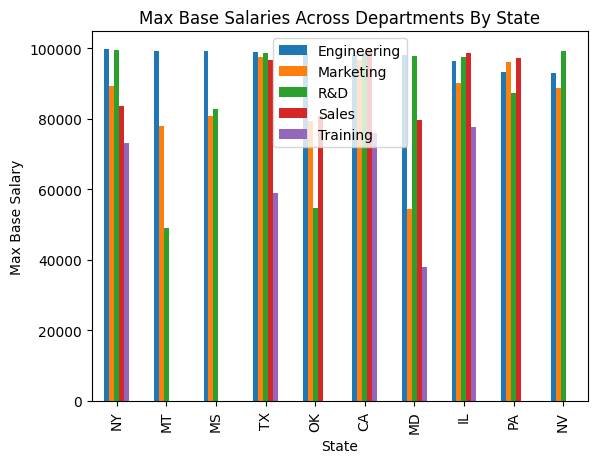

In [4]:
# Group employees by State and then calculate the max base salary across each department, sorting on 
# the max base salary in the Engineering department. Then plot the data by converting the Spark DataFrame to 
# a pandas DataFrame - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html . 

from pyspark.sql.functions import desc
df.groupBy("State") \
  .pivot("Department") \
  .max("BaseSalary") \
  .orderBy(desc("Engineering")) \
  .limit(10) \
  .toPandas() \
  .plot(kind="bar", title="Max Base Salaries Across Departments By State", x=0, ylabel="Max Base Salary")

In [5]:
# Similar to the above example, but write the results as new documents to MarkLogic.

from pyspark.sql.functions import desc
df.groupBy("State") \
  .pivot("Department") \
  .max("BaseSalary") \
  .orderBy(desc("Engineering")) \
  .write \
  .format("com.marklogic.spark") \
  .option("spark.marklogic.client.uri", client_uri) \
  .option("spark.marklogic.write.permissions", "rest-reader,read,rest-writer,update") \
  .option("spark.marklogic.write.collections", "state-base-salaries") \
  .option("spark.marklogic.write.uriTemplate", "/state-base-salary/{State}.json") \
  .mode("append") \
  .save()

print("Finished writing documents to MarkLogic")

Finished writing documents to MarkLogic
